# WNBA Location Charts

Unfortunately, the same `stats.nba.com` endpoint cannot be used to generate WNBA shot charts. However, these data are available through `data.wnba.com`! This notebook uses the same methodology already followed for generating shot, foul, and assist charts.

The following explores the `wnba_shots.Shots` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `pbp` endpoint of the `data.wnba.com`. Because this is play-by-play data, the `Shots` name is a bit of a misnomer. The goal of this analysis is to build charts that visualize shooting, fouling, and passing data. Note, you will need version `1.0.1` of `py_ball` or the version currently on the `master` branch of the `py_ball` repository.

## Shot Charts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

import time

from py_ball import wnba_shots

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `Shots` class requires a few parameters:
- season: YYYY season year format
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 preseason game between the Mystics and the Dream.

In [2]:
game_id = '1011900011'
season = '2019'

shots = wnba_shots.Shots(headers=HEADERS,
                         game_id=game_id,
                         season=season)
shot_df = pd.DataFrame(shots.data)
shot_df.head(15)

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
0,10:00,Start Period,,12,2,0,0,-80,0,0,,0,0,20000,0,0,0
1,09:55,Jump Ball Williams vs Sanders (Sykes gains pos...,1628279,10,4,0,0,-80,0,1611661330,201506,0,0,60000,204322,1611661330,0
2,09:46,[ATL] Billings Layup Shot: Missed,,2,7,0,63,0,5,1611661330,,2,0,70000,1628881,1611661330,0
3,09:46,[WAS] Team Rebound,,4,8,0,63,0,0,1611661330,,0,0,80000,0,1611661322,0
4,09:27,[ATL] Sykes Turnover : Bad Pass (1 TO) Steal:A...,,5,9,0,81,172,1,1611661330,1628878,1,0,90000,1628279,1611661330,0
5,09:17,[WAS] Toliver Jump Shot: Missed,,2,11,0,-125,163,1,1611661322,,2,0,110000,201911,1611661322,0
6,09:11,[ATL] Hayes Rebound (Off:0 Def:1),,4,12,0,-125,163,0,1611661322,,0,0,120000,203026,1611661330,0
7,08:43,[ATL] Hayes Jump Shot: Missed,,2,13,0,-69,155,1,1611661330,,2,0,130000,203026,1611661330,0
8,08:37,[ATL] Team Rebound,,4,14,0,-69,155,0,1611661330,,1,0,140000,0,1611661330,0
9,08:33,[ATL 2-0] Hayes Jump Shot: Made (2 PTS) Assist...,201904,1,15,2,-144,0,1,1611661330,,2,0,150000,203026,1611661330,0


Let's attempt to define as many columns as we can:
- `cl`: Game time remaining in the period in MM:SS format
- `de`: Play description
- `epid`:
- `etype`: Event type indicators. Viewing the above seems to indicate that a 1 is a made shot, 2 is a missed shot, and 4 is a rebound.
- `evt`: This appears to be an order of events.
- `hs`: Home score
- `locX`: x-location of the play
- `locY`: y-location of the play
- `mtype`:
- `pid`: Player ID of the main actor on a play
- `tid`: Team ID of the main actor on a play
- `oftid`: Team ID of the offensive team
- `vs`: Visitor score

The following draws a WNBA half court on which the shot charts will be plotted.

In [31]:
def draw_court():
    """ draw_court draws an WNBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an WNBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 35], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 35], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=222.17*2, height=222.17*2, theta1=8, theta2=172, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

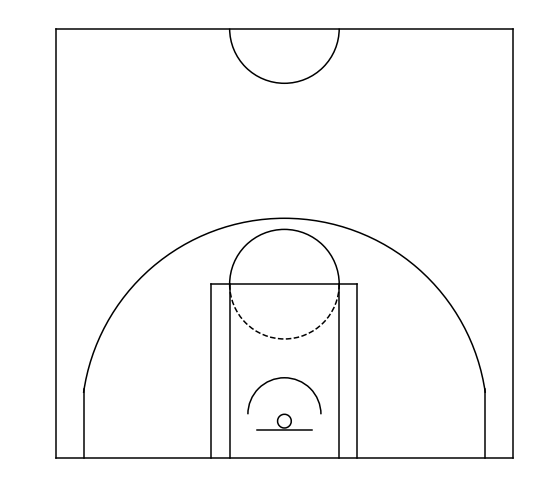

In [32]:
court, court_axis = draw_court()
court

With the court visualization, the next step is to write a function that plots shots for a given player or team.

In [40]:
def plot_shot(shot_df, player_or_team, unit_id):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df[shot_df['tid']==unit_id]
        court_axis.set_title('Washington Mystics', fontsize=14)
    else:
        shot = shot_df[shot_df['pid']==unit_id]
        court_axis.set_title('Shatori Walker-Kimbrough', fontsize=14)

    miss_df = shot[shot['etype']==2]
    make_df = shot[shot['etype']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['locX'], make_df['locY'], 'ko', alpha=0.5, label='Make')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['locX'], miss_df['locY'], 'kx', alpha=0.5, label='Miss')

    plt.legend(loc='upper right')
    plt.close()
    return court

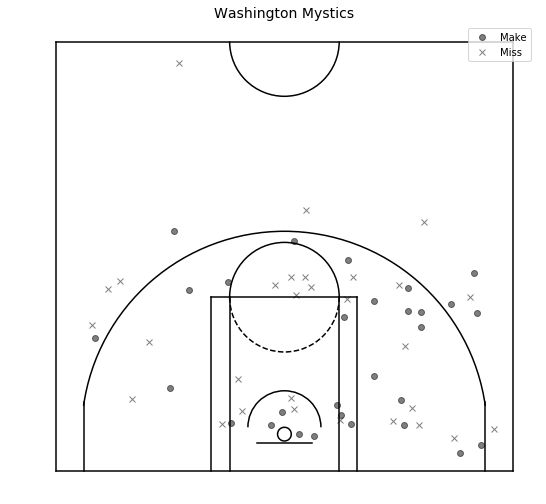

In [41]:
plot_shot(shot_df, 'team', 1611661322)

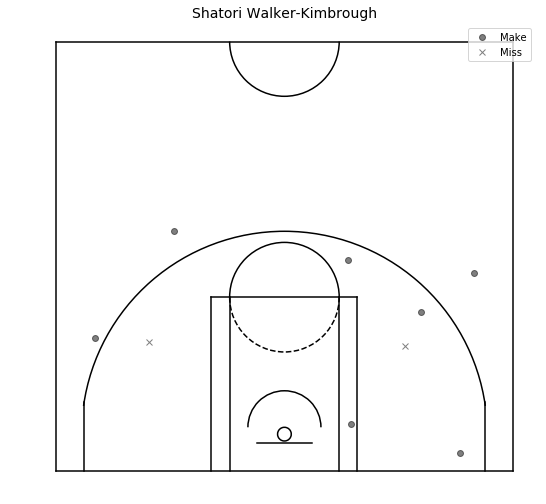

In [42]:
plot_shot(shot_df, 'player', 1628278)

Shatori Walker-Kimbrough had a great shooting performance, going 7-9 from the field including 3-3 from three-point land for 15 points.